In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import numpy as np
import os
os.environ["JAXTYPING_DISABLE"] = "1"
import torch
import skshapes as sks
from matplotlib.path import Path

%load_ext autoreload
%autoreload 2
import func as f

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


# Création des données "jouet"

In [2]:
# DEFINITION DES PARAMETRES DES OBJETS JOUET
# Tumeur
centre_tumeur = np.array([3.0, 2.0])
rayon_tumeur = 1.5

# Zone d'ablation
marge = 1.0  # 1 cm
rayon_ablation = rayon_tumeur + marge

# Paramètres de la rétractation (ground truth)
FORCE_RETRACTATION = 1 # Assez fort pour être visible
RAYON_INFLUENCE = rayon_ablation # Assez large pour toucher les vaisseaux

# Vaisseau A
start_angle_A = 0
end_angle_A = 360
rayon_vaisseau_A = rayon_ablation + 0.5  # Positionné à l'extérieur de la zone d'ablation

# Vaisseau B
start_angle_B = 0
end_angle_B = 180
rayon_vaisseau_B = rayon_ablation + 0.5  # Positionné à l'extérieur de la zone d'ablation

# CREATION DES OBJETS JOUET (PRE-OP)
# Foie
foie_pre = f.get_liver_shape()

# Tumeur
tumeur_pre = f.get_circle(centre_tumeur, rayon_tumeur)

# Zone d'Ablation (ground truth)
zone_ablation_pre = f.get_circle(centre_tumeur, rayon_ablation)

# Réseau de vaisseaux 1
arc_pre_A = f.get_arc_vessel(centre_tumeur, radius_vessel=rayon_vaisseau_A, start_angle=start_angle_A,  end_angle=end_angle_A)
vaisseaux_pre_1 = [arc_pre_A]

# Réseau de vaisseaux 2
arc_pre_B = f.get_arc_vessel(centre_tumeur, radius_vessel=rayon_vaisseau_B, start_angle=start_angle_B,  end_angle=end_angle_B)
vaisseaux_pre_2 = [arc_pre_B]

# --- NOUVEAUX PARAMÈTRES ---
NOMBRE_ARCS = 30          # On passe à 30 arcs
ANGLE_OUVERTURE = 22.5    # Arcs plus petits (22.5 degrés)
DIST_MAX_DU_CENTRE = 12  # J'ai légèrement augmenté pour bien remplir tout le foie

# On récupère le contour pour les tests (au cas où ce n'est pas déjà fait)
path_foie = Path(foie_pre)

vaisseaux_pre_3 = []

# --- BOUCLE DE GÉNÉRATION ---
compteur_securite = 0
while len(vaisseaux_pre_3) < NOMBRE_ARCS and compteur_securite < 2000:
    compteur_securite += 1
    
    # 1. Tirage aléatoire
    # Rayon : Toujours hors de la zone d'ablation (+1 marge), jusqu'au bord
    r_alea = np.random.uniform(rayon_ablation + 1, DIST_MAX_DU_CENTRE)
    
    # Angle
    angle_start_alea = np.random.uniform(0, 360)
    angle_end_alea = angle_start_alea + ANGLE_OUVERTURE
    
    # 2. Création de l'arc candidat
    arc_candidat = f.get_arc_vessel(
        centre_tumeur, 
        radius_vessel=r_alea, 
        start_angle=angle_start_alea, 
        end_angle=angle_end_alea
    )
    
    # 3. Vérification : Dedans ou Dehors ?
    is_inside = path_foie.contains_points(arc_candidat)
    
    # On garde seulement si TOUT l'arc est dans le foie
    if np.all(is_inside):
        vaisseaux_pre_3.append(arc_candidat)

# SIMULATION DE L'INTERVENTION (POST-OP)
# On applique ta fonction apply_retraction à TOUT le monde
foie_post = f.apply_retraction(foie_pre, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)

# Note: La tumeur n'existe plus physiquement, mais on calcule la déformation de l'espace
# La zone d'ablation visible est la version rétractée de la zone théorique
zone_ablation_post = f.apply_retraction(zone_ablation_pre, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)

vaisseaux_post_1 = []
for segment in vaisseaux_pre_1:
    seg_post = f.apply_retraction(segment, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)
    vaisseaux_post_1.append(seg_post)

vaisseaux_post_2 = []
for segment in vaisseaux_pre_2:
    seg_post = f.apply_retraction(segment, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)
    vaisseaux_post_2.append(seg_post)

# --- SIMULATION POST-OP ---
vaisseaux_post_3 = []
for segment in vaisseaux_pre_3:
    seg_post = f.apply_retraction(segment, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)
    vaisseaux_post_3.append(seg_post)

# Conversion en objets polydata

In [3]:
# CRÉATION DES COMPOSANTS DE BASE
# On utilise les variables générées dans l'étape précédente :
# foie_pre, foie_post, vaisseaux_pre, vaisseaux_post, zone_ablation_pre, zone_ablation_post

# -- PRE-OP --
mesh_foie_pre = f.curve_to_polydata(foie_pre, is_closed=True)
mesh_vaisseaux_pre_1 = f.merge_vessels(vaisseaux_pre_1)
mesh_vaisseaux_pre_2 = f.merge_vessels(vaisseaux_pre_2)
mesh_vaisseaux_pre_3 = f.merge_vessels(vaisseaux_pre_3)
mesh_ablation_pre = f.curve_to_polydata(zone_ablation_pre, is_closed=True)

# -- POST-OP --
mesh_foie_post = f.curve_to_polydata(foie_post, is_closed=True)
mesh_vaisseaux_post_1 = f.merge_vessels(vaisseaux_post_1)
mesh_vaisseaux_post_2 = f.merge_vessels(vaisseaux_post_2)
mesh_vaisseaux_post_3 = f.merge_vessels(vaisseaux_post_3)
mesh_ablation_post = f.curve_to_polydata(zone_ablation_post, is_closed=True)


# ASSEMBLAGE DES STRUCTURES COMPLÈTES

# Structures registration SOURCE (Pre-Op : Foie + Vaisseaux)
structure_1_pre_reg = mesh_foie_pre + mesh_vaisseaux_pre_1
structure_2_pre_reg = mesh_foie_pre + mesh_vaisseaux_pre_2
structure_3_pre_reg = mesh_foie_pre + mesh_vaisseaux_pre_3

# Structures registration TARGET (Post-Op : Foie + Vaisseaux)
structure_1_post_reg = mesh_foie_post + mesh_vaisseaux_post_1
structure_2_post_reg = mesh_foie_post + mesh_vaisseaux_post_2
structure_3_post_reg = mesh_foie_post + mesh_vaisseaux_post_3

# Structure validation SOURCE (Pre-Op : Foie + Vaisseaux + Ablation)
# Celle-ci sert de "Vérité Terrain" complète
structure_pre_full = mesh_foie_pre + mesh_ablation_pre

# Structure validation TARGET (Post-Op : Foie + Vaisseaux + Ablation)
# Celle-ci sert à vérifier visuellement la rétractation avant correction
structure_post_full = mesh_foie_post + mesh_ablation_post

# Simulation 1 : scénario du pire, on n'a accès qu'à la déformation du foie

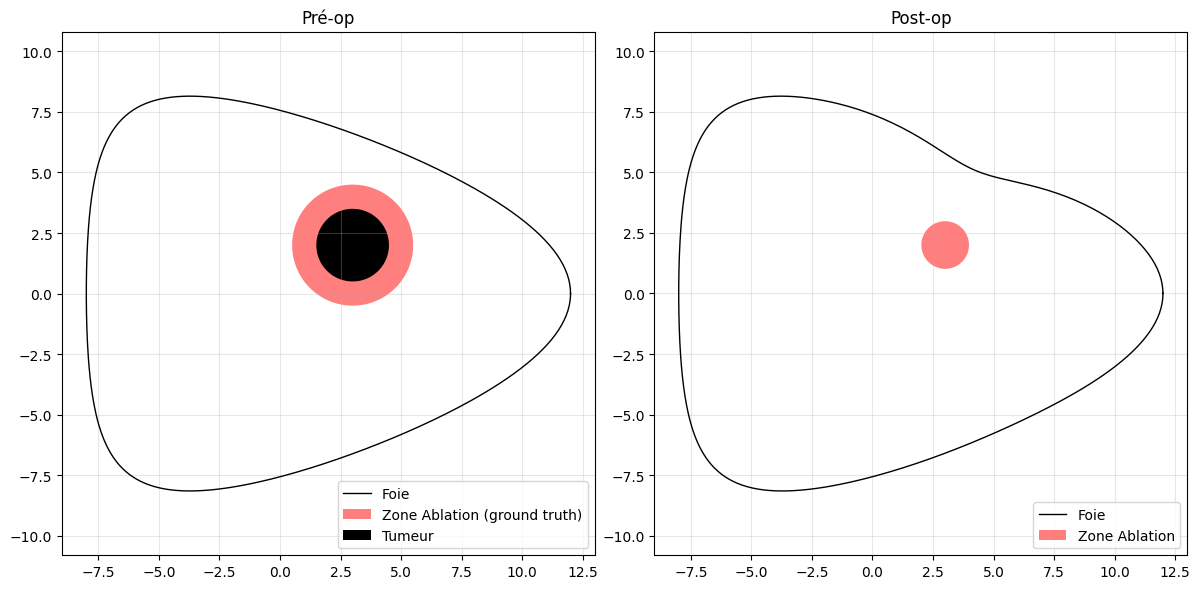

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 2.87e-02
  = 2.87e-02 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 8.22e-04
  = 2.18e-04 + 0.001 * 6.04e-01 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 7.94e-04
  = 1.96e-04 + 0.001 * 5.98e-01 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 7.79e-04
  = 1.74e-04 + 0.001 * 6.06e-01 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 7.74e-04
  = 1.67e-04 + 0.001 * 6.07e-01 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 7.74e-04
  = 1.67e-04 + 0.001 * 6.07e-01 (fidelity + regularization_weight * regularization)
Terminé !


Widget(value='<iframe src="http://localhost:50869/index.html?ui=P_0x177447d50_0&reconnect=auto" class="pyvista…

In [4]:
f.visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    [],  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    []
)

# 1. CHARGEMENT
source = sks.PolyData(mesh_foie_pre)
target = sks.PolyData(mesh_foie_post)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()


registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

f.visualiser_zoom_grid(source, target, morphed)

# Simulation 2 : scénario idéal, un vaisseau fait le tour de la zone d'ablation

## 1) Registration pre-op -> post-op

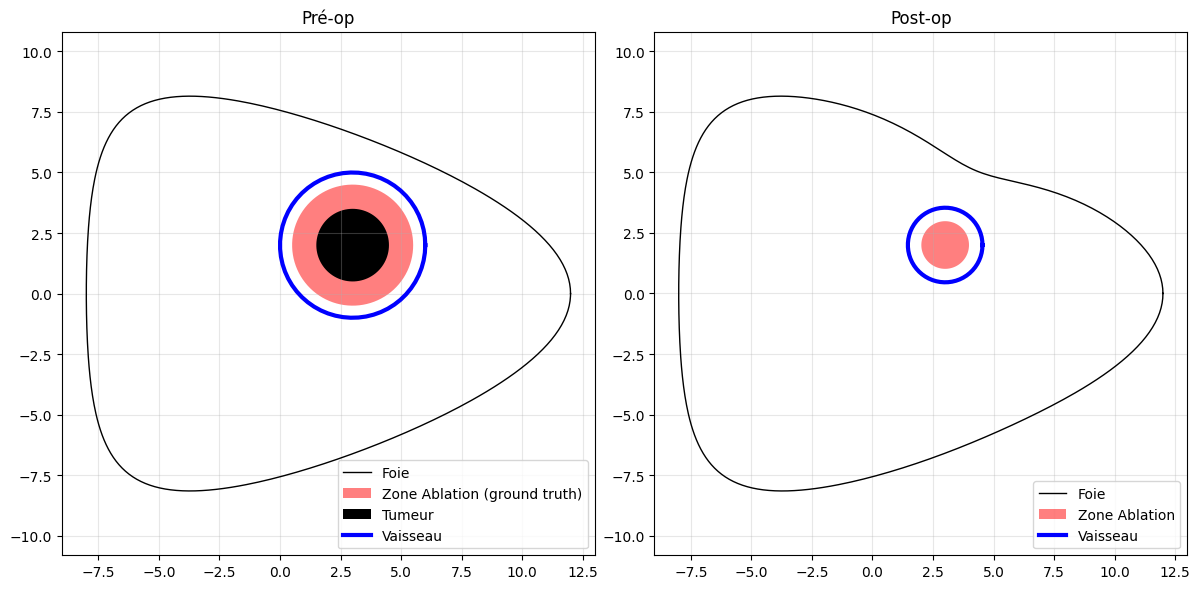

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 4.32e-01
  = 4.32e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 5.59e-03
  = 1.63e-04 + 0.001 * 5.43e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 5.48e-03
  = 1.33e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 5.48e-03
  = 1.33e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 5.48e-03
  = 1.33e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 5.48e-03
  = 1.33e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Terminé !


Widget(value='<iframe src="http://localhost:50869/index.html?ui=P_0x31557f110_1&reconnect=auto" class="pyvista…

In [5]:
f.visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    vaisseaux_pre_1,  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    vaisseaux_post_1
)

# 1. CHARGEMENT
source = sks.PolyData(structure_1_pre_reg)
target = sks.PolyData(structure_1_post_reg)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

f.visualiser_zoom_grid(source, target, morphed)

## 2) Estimation de la zone d'ablation

In [6]:
source = sks.PolyData(structure_1_post_reg)
target = sks.PolyData(structure_1_pre_reg)

source.control_points = source.bounding_grid(N=25, offset=0.2)

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    scale=1.5,  # Scale fin pour capturer la courbure des vaisseaux
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5,
    verbose=True,
    regularization_weight=0.001 
)

print("--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---")
# On déforme le Post-Op pour qu'il "gonfle" et revienne sur le Pre-Op
registration.fit(source=source, target=target)
print("--- RECALAGE TERMINÉ ---")

# 1. On charge la forme complète Post-Op
structure_validation_source = sks.PolyData(structure_post_full)

# 2. ON GREFFE LA GRILLE (Indispensable)
# On réutilise la grille qui a servi à calculer la déformation
structure_validation_source.control_points = source.control_points

print("Application de la déformation...")

# 3. MORPHING
# On utilise parameter_ et on récupère l'objet résultat
morphing_output = registration.model.morph(
    shape=structure_validation_source,
    parameter=registration.parameter_
)

# 4. EXTRACTION DE LA FORME
# C'est ici qu'on récupère le vrai objet PolyData
structure_finale = morphing_output.morphed_shape

print("✅ Déformation appliquée et forme extraite !")

f.visualiser_validation_only(
    verite_terrain=structure_pre_full, 
    resultat_recale=structure_finale
)

--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---
Initial loss : 4.32e-01
  = 4.32e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 5.79e-03
  = 2.65e-04 + 0.001 * 5.52e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 5.54e-03
  = 1.84e-04 + 0.001 * 5.35e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 5.51e-03
  = 1.79e-04 + 0.001 * 5.33e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 5.51e-03
  = 1.79e-04 + 0.001 * 5.33e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 5.51e-03
  = 1.79e-04 + 0.001 * 5.33e+00 (fidelity + regularization_weight * regularization)
--- RECALAGE TERMINÉ ---
Application de la déformation...
✅ Déformation appliquée et forme extraite !


Widget(value='<iframe src="http://localhost:50869/index.html?ui=P_0x1455fec10_2&reconnect=auto" class="pyvista…

# Simulation 3 : scénario intermédiaire, un vaisseau ne passe que d'un côté de la zone d'ablation

## 1) Registration pre-op -> post-op

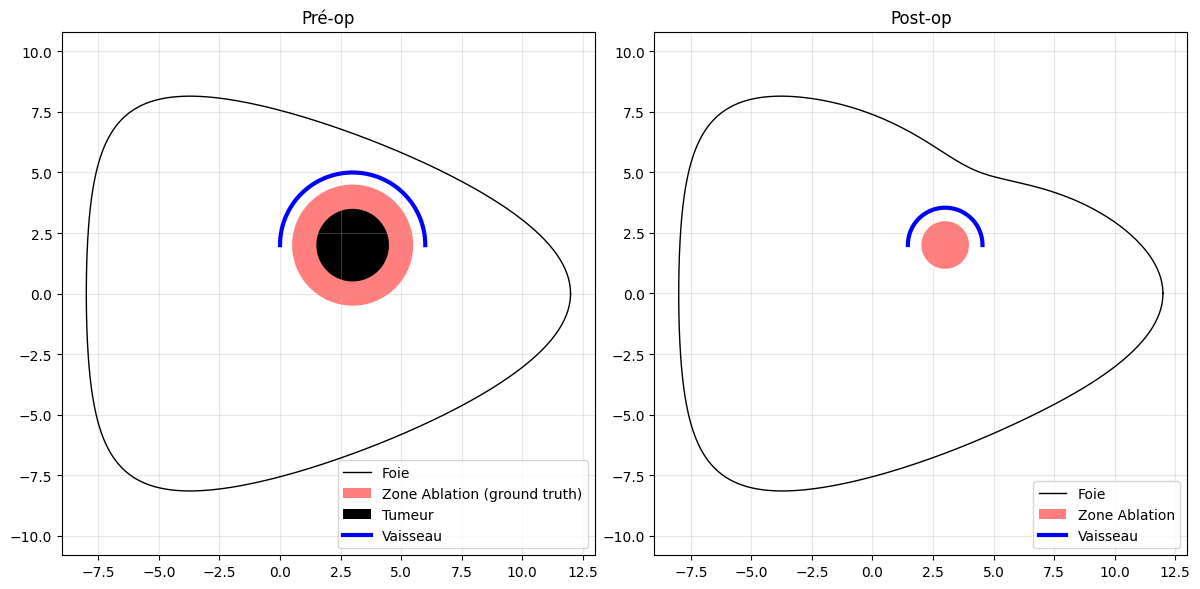

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 2.62e-01
  = 2.62e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 4.03e-03
  = 3.21e-04 + 0.001 * 3.71e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 3.91e-03
  = 2.70e-04 + 0.001 * 3.64e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 3.87e-03
  = 2.53e-04 + 0.001 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 3.87e-03
  = 2.53e-04 + 0.001 * 3.62e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 3.87e-03
  = 2.53e-04 + 0.001 * 3.62e+00 (fidelity + regularization_weight * regularization)
Terminé !


Widget(value='<iframe src="http://localhost:50869/index.html?ui=P_0x31fc5e110_3&reconnect=auto" class="pyvista…

In [7]:
f.visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    vaisseaux_pre_2,  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    vaisseaux_post_2
)

# 1. CHARGEMENT
source = sks.PolyData(structure_2_pre_reg)
target = sks.PolyData(structure_2_post_reg)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

f.visualiser_zoom_grid(source, target, morphed)

## 2) Estimation de la zone d'ablation

In [8]:
source = sks.PolyData(structure_2_post_reg)
target = sks.PolyData(structure_2_pre_reg)

source.control_points = source.bounding_grid(N=25, offset=0.2)

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    scale=1.5,  # Scale fin pour capturer la courbure des vaisseaux
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5,
    verbose=True,
    regularization_weight=0.001 
)

print("--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---")
# On déforme le Post-Op pour qu'il "gonfle" et revienne sur le Pre-Op
registration.fit(source=source, target=target)
print("--- RECALAGE TERMINÉ ---")

# 1. On charge la forme complète Post-Op
structure_validation_source = sks.PolyData(structure_post_full)

# 2. ON GREFFE LA GRILLE (Indispensable)
# On réutilise la grille qui a servi à calculer la déformation
structure_validation_source.control_points = source.control_points

print("Application de la déformation...")

# 3. MORPHING
# On utilise parameter_ et on récupère l'objet résultat
morphing_output = registration.model.morph(
    shape=structure_validation_source,
    parameter=registration.parameter_
)

# 4. EXTRACTION DE LA FORME
# C'est ici qu'on récupère le vrai objet PolyData
structure_finale = morphing_output.morphed_shape

print("✅ Déformation appliquée et forme extraite !")

f.visualiser_validation_only(
    verite_terrain=structure_pre_full, 
    resultat_recale=structure_finale
)

--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---
Initial loss : 2.62e-01
  = 2.62e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 4.51e-03
  = 6.24e-04 + 0.001 * 3.89e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 4.14e-03
  = 4.34e-04 + 0.001 * 3.71e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 4.09e-03
  = 4.34e-04 + 0.001 * 3.65e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 4.06e-03
  = 4.15e-04 + 0.001 * 3.64e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 4.06e-03
  = 4.15e-04 + 0.001 * 3.64e+00 (fidelity + regularization_weight * regularization)
--- RECALAGE TERMINÉ ---
Application de la déformation...
✅ Déformation appliquée et forme extraite !


Widget(value='<iframe src="http://localhost:50869/index.html?ui=P_0x31fd87050_4&reconnect=auto" class="pyvista…

# Simulation 4 : scénario réaliste avec des vaisseaux répartis dans le foie

## 1) Registration pre-op -> post-op

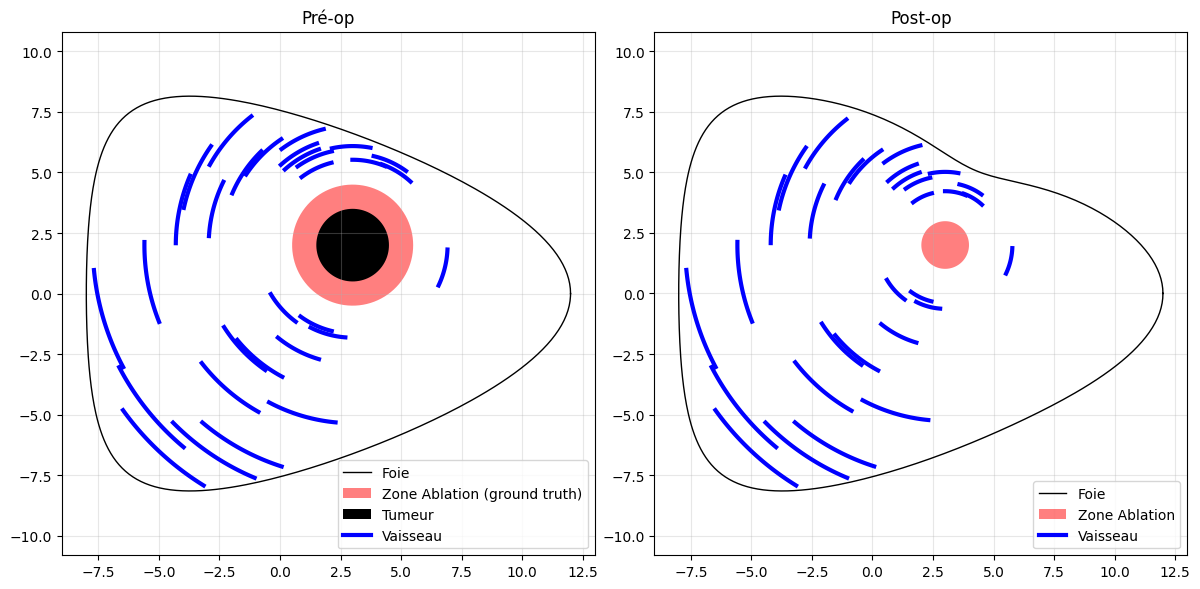

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 1.43e-01
  = 1.43e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 3.85e-03
  = 3.90e-04 + 0.001 * 3.46e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 3.62e-03
  = 3.51e-04 + 0.001 * 3.27e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 3.59e-03
  = 3.36e-04 + 0.001 * 3.25e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 3.58e-03
  = 3.31e-04 + 0.001 * 3.25e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 3.58e-03
  = 3.31e-04 + 0.001 * 3.25e+00 (fidelity + regularization_weight * regularization)
Terminé !


Widget(value='<iframe src="http://localhost:50869/index.html?ui=P_0x31faa3f90_5&reconnect=auto" class="pyvista…

In [9]:
f.visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    vaisseaux_pre_3,  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    vaisseaux_post_3
)

# 1. CHARGEMENT
source = sks.PolyData(structure_3_pre_reg)
target = sks.PolyData(structure_3_post_reg)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

f.visualiser_zoom_grid(source, target, morphed)

## 2) Estimation de la zone d'ablation

In [10]:
source = sks.PolyData(structure_3_post_reg)
target = sks.PolyData(structure_3_pre_reg)

source.control_points = source.bounding_grid(N=25, offset=0.2)

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    scale=1.5,  # Scale fin pour capturer la courbure des vaisseaux
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=5,
    verbose=True,
    regularization_weight=0.001 
)

print("--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---")
# On déforme le Post-Op pour qu'il "gonfle" et revienne sur le Pre-Op
registration.fit(source=source, target=target)
print("--- RECALAGE TERMINÉ ---")

# 1. On charge la forme complète Post-Op
structure_validation_source = sks.PolyData(structure_post_full)

# 2. ON GREFFE LA GRILLE (Indispensable)
# On réutilise la grille qui a servi à calculer la déformation
structure_validation_source.control_points = source.control_points

print("Application de la déformation...")

# 3. MORPHING
# On utilise parameter_ et on récupère l'objet résultat
morphing_output = registration.model.morph(
    shape=structure_validation_source,
    parameter=registration.parameter_
)

# 4. EXTRACTION DE LA FORME
# C'est ici qu'on récupère le vrai objet PolyData
structure_finale = morphing_output.morphed_shape

print("✅ Déformation appliquée et forme extraite !")

f.visualiser_validation_only(
    verite_terrain=structure_pre_full, 
    resultat_recale=structure_finale
)

--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---
Initial loss : 1.43e-01
  = 1.43e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 3.79e-03
  = 4.41e-04 + 0.001 * 3.35e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 3.65e-03
  = 4.15e-04 + 0.001 * 3.23e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 3.61e-03
  = 3.94e-04 + 0.001 * 3.22e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 3.58e-03
  = 3.82e-04 + 0.001 * 3.20e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 3.58e-03
  = 3.82e-04 + 0.001 * 3.20e+00 (fidelity + regularization_weight * regularization)
--- RECALAGE TERMINÉ ---
Application de la déformation...
✅ Déformation appliquée et forme extraite !


Widget(value='<iframe src="http://localhost:50869/index.html?ui=P_0x31fceb290_6&reconnect=auto" class="pyvista…